# Nudged Elastic Band gradient calculations
Cost functions for NEB will be broken down always into two parts. The first part is the gradient due to some objective function ($g$) and the second is an modifying force felt between two of the band members ($s$). The overall cost will be the sum of all forces on each member of the band. For these problems, we call  the dimension that each band lives in $n$, and the number
of band members $m$. Each member will be refered to as $x_i$ where $i$ is a number between $0$ and $m-1$. Since we are considering problems where the end points are known, there will be no gradient to move either of the end points of the band.

$f(x_i) = \sum_{i=1}^{m-2} g(x_i) + \sum_{i=1}^{m-2}s(x_i)$

As a condition, the gradient will never adjust the start and end locations, these are constraints of the problem. For the remainder of the problems, without loss of generality, I'll use $n=2,m=10$.

Because the only the interior points can move, the gradient will only be $(m-2) * n)$ in size.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy import *
n = 2
m = 10

In [56]:
class NEB:
    '''
    optimziation locations stored by variable x as shape n by m
    '''
    def __init__(self, x, k=1e-2, spring_type = 'quadratic', projected = False):
        self.x , self.spring_type, self.k, self.projected = x, spring_type,k,projected
        self.m = x.shape[0]
        self.n = x.shape[1]
        self.solved = False
        self.tol = 1e-6
        
    def spring_cost(self, x = None):
        if x is None: x = self.x[1:-1,:]
        X = self.x
        X[1:-1,:] = x.reshape(self.m-2,self.n)
        left  = X[0:-1,:]
        right = X[1:,  :]
        spring_potential = np.linalg.norm(left - right, axis=1)
        return np.sum(spring_potential * self.k)
    
    def quad_spring_gradient(self, x = None):
        if x is None: x = self.x[1:-1,:].flatten()
        X = self.x
        X[1:-1,:] = x.reshape(self.m-2,self.n)
        spring_force = self.k * ( 
                       (X[1:-1,:] - X[0:-2,:]) + 
                       (X[1:-1,:] - X[2:  ,:])
                       )
        return spring_force.flatten()
    
    def linear_spring_gradient(self, x = None):
        if x is None: x = self.x[1:-1,:].flatten()
        X = self.x
        X[1:-1,:] = x.reshape(self.m-2,self.n)
        spring_force = self.k * ( 
                       (X[1:-1,:] - X[0:-2,:])/np.linalg.norm(X[1:-1,:] - X[0:-2,:], axis=1)[:,None] + 
                       (X[1:-1,:] - X[2:  ,:])/np.linalg.norm(X[1:-1,:] - X[2:  ,:], axis=1)[:,None]
                       )
        return spring_force.flatten()
    
    def obj_cost(self,x = None):
        return 0
    
    def obj_gradient(self, x = None):
        return np.zeros( (self.m - 2) * self.n )
    
    def cost(self, x = None):
        return self.spring_cost(x) + self.obj_cost(x)
    
    def gradient(self, x = None):
        objective = self.obj_gradient(x)
        if self.spring_type == 'quadratic':
            spring = self.quad_spring_gradient(x) 
        if self.spring_type == 'linear':
            spring = self.linear_spring_gradient(x) 
        if x is None: x = self.x[1:-1,:].flatten()
        
        spring = spring.reshape(self.m-2,self.n)
        objective = objective.reshape(self.m-2,self.n)
        
        if self.projected == False: return (spring + objective).flatten()
        else:
            X = self.x
            X[1:-1,:] = x.reshape(self.m-2,self.n)
            tau =  X[2:,:] - X[0:-2,:]
            tau/=np.linalg.norm(tau,axis=1)[:,None]
            spring_par = np.sum(spring * tau,axis=1)[:,None] * tau
            object_par = np.sum(objective * tau,axis=1)[:,None] * tau
            object_perp = objective - object_par
            return (spring_par + object_perp).flatten()
    
    def plot(self):
        if self.n == 2:
            plt.scatter(self.x[0,0],self.x[0,1],color='b')
            plt.scatter(self.x[-1,0],self.x[-1,1],color='b')
            plt.scatter(self.x[1:-1,0],self.x[1:-1,1],color='r')
            plt.plot(self.x[:,0], self.x[:,1])
            plt.show()
                
            
    def minimize(self):
        x0 = self.x[1:-1,:].flatten()
        fun = self.cost
        jac = self.gradient
        result = minimize(fun,x0,jac=jac,method='BFGS', tol=1e-12, options=
                          dict(gtol=self.tol * self.k, norm=2, disp=True, maxiter = 10000, return_all=True))
        self.x[1:-1,:] = result.x.reshape(self.m-2,self.n)
        self.history = np.array(result.allvecs)
        self.solved = result.success


## $s(x_i)$ for a common spring problem

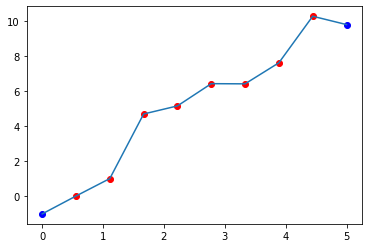

In [4]:
m = 10
e1 = np.linspace(0,5,m)
e2 = e1 * 2 + np.random.randn(m)
x = np.vstack([e1,e2]).T # Initialize x with end points and some noise
spring = NEB(x)
spring.plot()

### Definining the spring cost function
Spring cost function is defined as a constant multiplied by the $l_2$ norm distance between each band piece. We note that each member of the band will feel a force from its neighbors
and we can write the cost function for a single band point as:
$ s(x_i) =  k||x_i - x_{i-1}||_2^2 + k||x_{i+1} - x_{i}||_2^2 $
We note that we can differentiate with respect to $x_i$ as arrive at the following:
$ \nabla s(x_i) = k ( x_i - x_{i-1} + x_{i+1} - x_{i} )$
This is the gradient of the spring cost function with respect to a single band point, and will represent the restoring force on each element. Using the picture above as an example, the red points are allowed to move to reduce the overall energy of the spring

### Optimizing with Scipy
For the purposes of this optimizer, I haven't reinvented the wheel. I feed the cost function and gradient into scipy optimize and use the BFGS decent algorithm

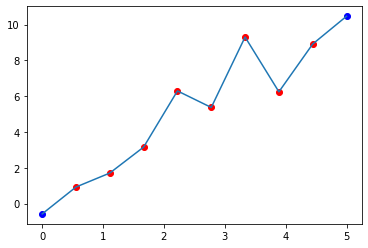

Optimization terminated successfully.
         Current function value: 12.120559
         Iterations: 64
         Function evaluations: 103
         Gradient evaluations: 103


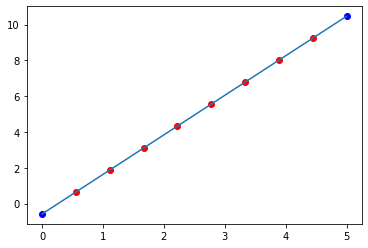

In [60]:
m = 10
e1 = np.linspace(0,5,m)
e2 = e1 * 2 + np.random.randn(m)
x = np.vstack([e1,e2]).T # Initialize x with end points and some noise
spring = NEB(x,k = 1)
spring.plot()
spring.minimize()
spring.plot()

### Minimum Energy of a Constant force field
Now we consider a problem like a gravity potential field, where the potential of the system is dependent on a single variable like height, and therefore has a constant gradient everywhere.

The potential function for this system looks like $g(x_i) = m g h$, where $m$ is mass, $g$ is gravitational constant, and $h$ is some height. We redfine a NEB's internal cost function and resolve bellow

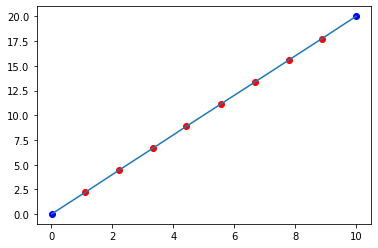

Optimization terminated successfully.
         Current function value: 935.492012
         Iterations: 9
         Function evaluations: 17
         Gradient evaluations: 17


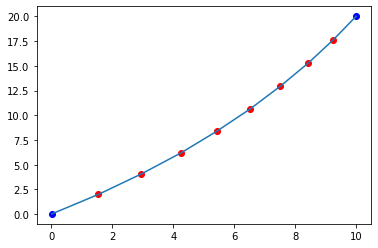

In [84]:
class Catenary(NEB):
    def __init__(self, x, k=20, mg =5, spring_type = 'quadratic', projected = True):
        self.x , self.spring_type, self.k, self.mg, self.projected = x, spring_type,k,mg, projected
        self.m = x.shape[0]
        self.n = x.shape[1]
        self.solved = False
        self.tol = self.m  * 1e-2
        
    def obj_cost(self, x = None):
        if x is None: x = self.x[1:-1,:]
        X = self.x
        X[1:-1,:] = x.reshape(self.m-2,self.n)
        return np.sum((X[:,1]) * self.mg)
    
    def obj_gradient(self, x = None):
        if x is None: x = self.x[1:-1,:].flatten()
        X = self.x
        X[1:-1,:] = x.reshape(self.m-2,self.n)
        spring_force = self.k * ( 
                       (X[1:-1,:] - X[0:-2,:]) + 
                       (X[1:-1,:] - X[2:  ,:])
                       ).flatten()
        vertical_force = np.ones_like(X[1:-1,:]) * self.mg 
        vertical_force[:,0] = 0 # Null the x forces
        return vertical_force.flatten() + spring_force

m = 10
e1 = np.linspace(0,10,m) + np.random.randn(m) * .01
e2 = e1 * 2 + np.random.randn(m) * .01 
x = np.vstack([e1,e2]).T # Initialize x with end points and some noise
x = x.astype(np.float64)
catenary = Catenary(x)
catenary.plot()
catenary.minimize()
catenary.plot()

We see that the curve solved for indeed becomes the catenary that connects the two points